## What is SPySort?

SPySort is a spike sorting package written entirely in Python. It takes advantage of Numpy, Scipy, Matplotlib, Pandas and Scikit-learn. Below, you can find a brief how-to-use tutorial.

### Load the data
To begin with, we have to load our raw data. This can be done either by using the **import_data** module of SPySort or by using a custom loading function. In the case where the user would like to use the SPySort's methods to load its data he or she has to take into account the fact that the raw data must be in plain binary format. SPySort does not yet support reading other formats such as HDF5. Here we examine the case where the user decides to use the SPySort's methods. In the demonstration case below we have already the data available on our machine. If you would like to get the data you can use the following commands before performing any further analysis.

#### Download the data

In [1]:
import os
from urllib import urlretrieve
import matplotlib.pyplot as plt
%matplotlib inline 

data_names = ['Locust_' + str(i) + '.dat.gz' for i in range(1, 5)]
data_src = ['http://xtof.disque.math.cnrs.fr/data/'+ n for n in data_names]

[urlretrieve(data_src[i], data_names[i]) for i in range(4)] 

[os.system('gunzip ' + n) for n in data_names]

data_files_names = ['Locust_' + str(i) + '.dat' for i in range(1, 5)]

#### Load the data
Once we have downloaded the data, we load them using the module **import_data**. This module provides the method **read_data(filenames, frequency)**, which loads all the raw data. This method takes as input the filenames and the sampling frequency. 

At a next level, we can print the five numbers for each row (recording channel) using the method **five_numbers()**. The first column contains the minimal value; the second, the first quartile; the third, the median; the fourth, the third quartile; the fifth, the maximal value. Using these five numbers we can ensure that our data are proper for any further statistical analysis. Moreover, we check if some processing like a division by the standard deviation (SD) has been applied on our raw data by calling the method **checkStdDiv()**. Finally, we can obtain the size of the digitization set by calling the method **discreteStepAmpl()**.

In [2]:
import numpy as np
from spysort.ReadData import import_data

# Data analysis parameter
freq = 1.5e4    # Sampling frequency
win = np.array([1., 1., 1., 1., 1.])/5.  # Boxcar filter

# read_data instance
r_data = import_data.read_data(data_files_names, freq)   # Read raw data

print r_data.fiveNumbers()      # Prints the five numbers

print r_data.checkStdDiv()       # Check if our data have been divided by std

print r_data.discretStepAmpl()   # Print the discretization step amplitude 

[array([ -9.074,  -0.371,  -0.029,   0.326,  10.626]), array([ -8.229,  -0.45 ,  -0.036,   0.396,  11.742]), array([-6.89 , -0.53 , -0.042,  0.469,  9.849]), array([ -7.347,  -0.492,  -0.04 ,   0.431,  10.564])]
[0.99999833333194166, 0.99999833333193622, 0.99999833333194788, 0.99999833333174282]
[0.0067098450784115471, 0.0091945001879327748, 0.011888432902217971, 0.0096140421286605715]


### Preprossecing the data
Once we have loaded the raw data and we have check that the data range (maximum - minimum) is similar (close to 20) on the four recording sites and the inter-quartiles ranges are also similar in previously described five-numbers statistics, we can proceed to the renormalization of our data.

The renormalization can be done by calling the method **renormalization()** of the **import_data** module.
As one can notice in the following code snippet, the attribute timeseries is not of dimension one. Indeed, the **timeseries** atribute contains the renormalized data in its first dimension and theis corresponding timestamps in the second dimension. Finally, we can plot the renormalized raw data in order to visually inspect our data. 

The goal of the renormalization is to scale the raw data such that the noise SD is approximately 1. Since it is not straightforward to obtain a noise SD on data where both signal (i.e., spikes) and noise are present, we use this robust type of statistic for the SD. 

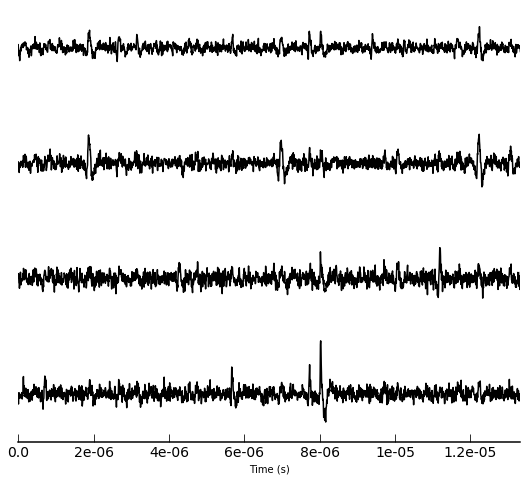

In [3]:
# Data normalization using MAD
r_data.timeseries[0] = r_data.renormalization()

r_data.plotData(r_data.data[0:300])  # Plot normalized data

Now, we have renormalized our data, but how we know that MAD does its job? In order to know if MAD indeed works, we can compute the Q-Q plots of the whole traces normalized with the MAD and normalized with the "classical" SD. This is implemented in SPySort's **chechMad()** method.

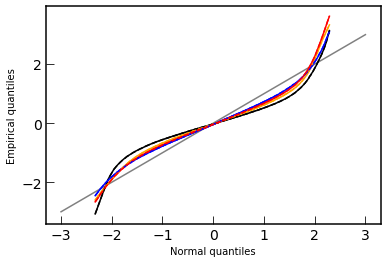

In [4]:
r_data.checkMad()

### Detect peaks
After the normalization of the raw data, we apply a threshold method in spite of detecting peaks (possible spike events) in our raw data. Before, detect any peaks we filter the data slightly using a "box" filter of length 3. This means that the data points of the original trace are going to be replaced by the average of themselves with their four nearest neighbors. We will then scale the filtered traces such that the MAD is one on each recording site and keep only the parts of the signal which are above a threshold. The threshold is an argument and can be set by the user easily. 

The peak detection can be done by creating a **spike_detection** instance and then calling the methods **filtering(threshold, window)** and **peaks(filtered_data, minimalDist, notZero, kind)**. The method **filtering()** takes as arguments a threshold value and the filtering window. The method **peaks()** takes as input arguments the filtered data, the minimal distance between two successive peaks, the smallest value above which the absolute value of the derivative is considered null and the sort of detection method. There are two choices for the detection method. The first one is the aggregate, where 
the data of all channels are summed up and then the detection is performed on the 
aggregated data. The second one is the classical method, where a peak detection is performed
on each signal separatelly. 

In [5]:
from spysort.Events import spikes

# Create a spike_detection instance
s = spikes.spike_detection(r_data.timeseries)

# Filter the data using a boxcar window filter of length 3 and a threshold value 4
filtered = s.filtering(4.0, win)

# Detect peaks over the filtered data
sp0 = s.peaks(filtered, kind='aggregate')

### Split the data
Depending on the nature of our raw data we can accelerate the spike sorting method by splitting our data into two or more sets. In the present example we split the data into two subsets and early and a later one. In sp0E (early), the number of detected events is: 908. On the other hand in sp0L (late), the number of detected events is: 887. Then we can plot our new filtered data sets and our detected peaks calling the methods **plotFilteredData(data, filteredData, threshold)** and **plotPeaks(data, positions)**, respectively.



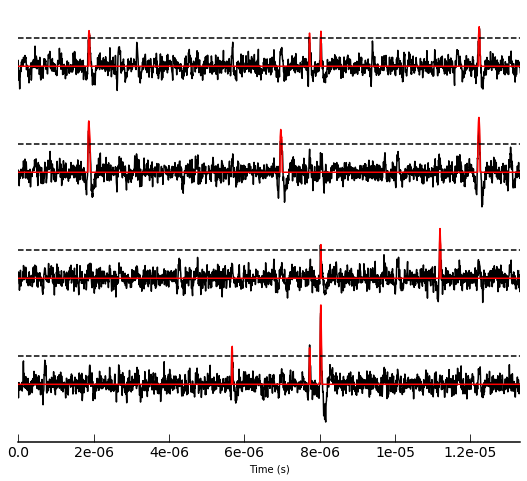

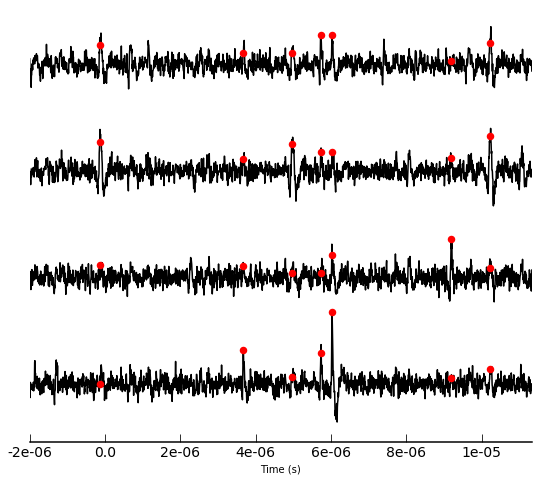

In [6]:
# We split our peak positions into two subsets (left and right)
sp0E = sp0[sp0 <= r_data.data_len/2.]
sp0L = sp0[sp0 > r_data.data_len/2.]

s.plotFilteredData(s.data, filtered, 4.)  # Plot the data
s.plotPeaks(s.data, sp0E)                   # Plot the peaks of the left subset

### Making cuts

After detecting our spikes, we must make our cuts in order to create our events' sample. The obvious question we must first address is: How long should our cuts be? The pragmatic way to get an answer is:
  
  + Make longer cuts, like 50 sampling points on both sides of the detected event's time.
  
  + Compute robust estimates of the "central" event (with the median) and of the dispersion of the
      sample around this central event (with the MAD).
  
  + Plot the two together and check when does the MAD trace reach the background noise level (at 1
       since we have normalized the data).
  
  + Having the central event allows us to see if it outlasts significantly the region where the MAD 
       is above the background noise level.
    
Clearly cutting beyond the time at which the MAD hits back the noise level should not bring any useful information as far a classifying the spikes is concerned. In this context, we use the method **mkEvents()** in order to build all the events and then we plot the MAD and the Median using the mehtod **plotMadMedia()**.

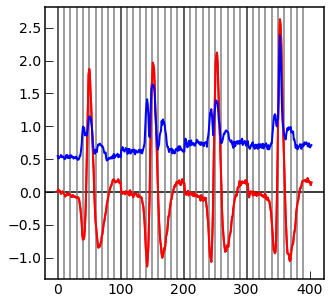

In [7]:
from spysort.Events import events

evts = events.build_events(r_data.data, sp0E, win, before=14, after=30)
evtsE = evts.mkEvents(otherPos=True, x=np.asarray(r_data.data) ,pos=sp0E, before=50, after=50)  # Make spike events

evts.plotMadMedian(evtsE)  # Plot mad and median of the events

### Events

Once we are satisfied with our spike detection, at least in a provisory way, and that we have decided on the length of our cuts, we proceed by making cuts around the detected events using the **mkEvents()** method once again. 

### Noise

Getting an estimate of the noise statistical properties is an essential ingredient to build respectable goodness of fit tests. In our approach "noise events" are essentially anything that is not an "event".

We could think that keeping a cut length on each side would be enough. That would indeed be the case if all events were starting from and returning to zero within a cut. But this is not the case with the cuts parameters we chose previously (that will become clear soon). You might wonder why we chose so short a cut length then. Simply to avoid having to deal with too many superposed events which are the really bothering events for anyone wanting to do proper sorting. To obtain our noise events we are going to use the method
**mkNoise()**.

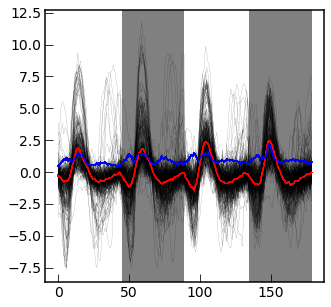

In [8]:
evtsE = evts.mkEvents()    # Make spike events
noise = evts.mkNoise()     # Make noise events

evts.plotEvents(evtsE)      # Plot events

### Getting "clean" events

Our spike sorting has two main stages, the first one consist in estimating a model and the second one consists in using this model to classify the data. Our model is going to be built out of reasonably "clean" events. Here by clean we mean events which are not due to a nearly simultaneous firing of two or more neurons; and simultaneity is defined on the time scale of one of our cuts. When the model will be subsequently used to classify data, events are going to decomposed into their (putative) constituent when they are not "clean", that is, superposition are going to be looked and accounted for.

In order to eliminate the most obvious superpositions we are going to use a rather brute force approach, looking at the sides of the central peak of our median event and checking if individual events are not too large there, that is do not exhibit extra peaks. We first define a function doing this job:

### Dimension reduction

[(0, -576.61794224907885), (1, -276.53159175880285), (2, -186.62984905302847), (3, -127.10551508861568), (4, -90.385106529223435), (5, -57.906325031919664), (6, -35.429504876530245), (7, -20.610159843611314), (8, -7.3309326071264422), (9, 1.2184518646396327)]


/usr/local/lib/python2.7/dist-packages/spysort-1.0.0b0-py2.7.egg/spysort/Events/clusters.py:97: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


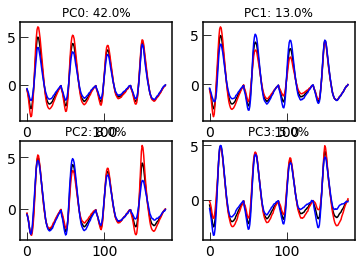

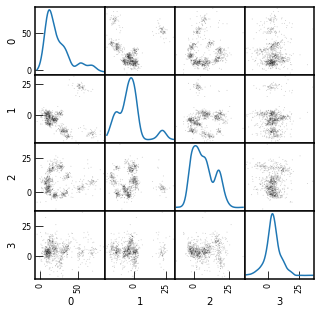

In [9]:
from spysort.Events import clusters

# Create a clusters instance
c = clusters.pca_clustering(r_data.timeseries[0], sp0E, win, thr=8, before=14, after=30)

print c.pcaVariance(10)   # Print the variance of the PCs

c.plotMeanPca()           # Plot the mean +- PC
c.plotPcaProjections()    # Plot the projections of the PCs on the data

### Clustering

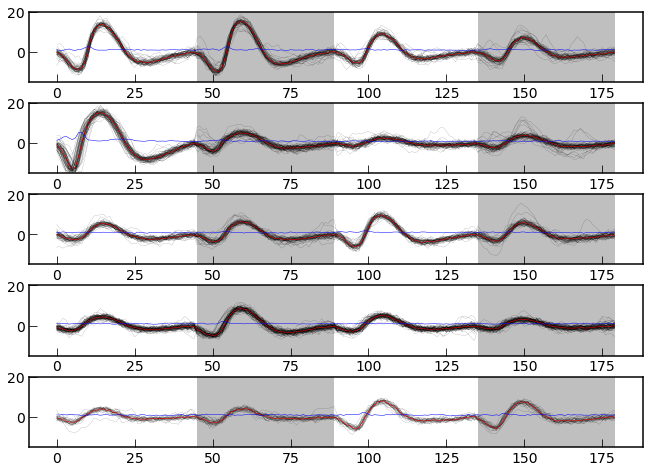

In [10]:
CSize = 10                           # Cluster size

kmeans_clusters = c.KMeans(CSize)    # K-means clustering

# gmmClusters = c.GMM(10, 'diag')    # GMM clustering

c.plotClusters(kmeans_clusters)      # Plot the clusters

### Spike "peeling"

In [13]:
from spysort.Events import alignment

#(data, positions, goodEvts, clusters, CSize, win=[],
#                 before=14, after=30, thr=3)

align =  alignment.align_events(r_data.data,sp0E,c.goodEvts,kmeans_clusters,CSize,win=win)


centers = {"Cluster " + str(i): align.mk_center_dictionary(sp0E[c.goodEvts][np.array(kmeans_clusters) == i])
           for i in range(CSize)}
# c10b
# Apply it to every detected event
# Warning do it like this
round0 = [align.classify_and_align_evt(sp0[i], centers) for i in range(len(sp0))]

print(len([x[1] for x in round0 if x[0] == '?']))

# Apply it
pred0 = align.predict_data(round0, centers)
data1 = np.array(r_data.timeseries[0]) - pred0

data_filtered = np.apply_along_axis(lambda x: np.convolve(x, np.array([1, 1, 1])/3.), 1, data1)
data_filtered = (data_filtered.transpose() / np.apply_along_axis(mad, 1, data_filtered)).transpose()
data_filtered[data_filtered < 4.] = 0
print data_filtered[0, :].shape

sp1 = s.peaks(data_filtered[0, :], kind='simple')
print(len(sp1))

round1 = [align.classify_and_align_evt(sp1[i], centers, otherData=True, 
           x=data1) for i in range(len(sp1))]

print(len([x[1] for x in round1 if x[0] == '?']))

pred1 = align.predict_data(round1, centers)
data2 = data1 - pred1

33


NameError: name 'mad' is not defined

In [ ]:
dir(alignment)